# Overcomplete Tomography

In [59]:
from octo.octo import OvercompleteBasis
from octo.basis import PixelBasis2D, CosineBasis2D
from octo.measurement import PathIntegral

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [60]:
rng = np.random.default_rng(42)

In [61]:
Nx = 20
Ny = 20
cosine = CosineBasis2D(Nx, Ny)
pixel = PixelBasis2D(Nx, Ny)
nparams = cosine.N + pixel.N

## Synthetic Data

Start by creating a ground truth image, combining global and local features

[(-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5)]

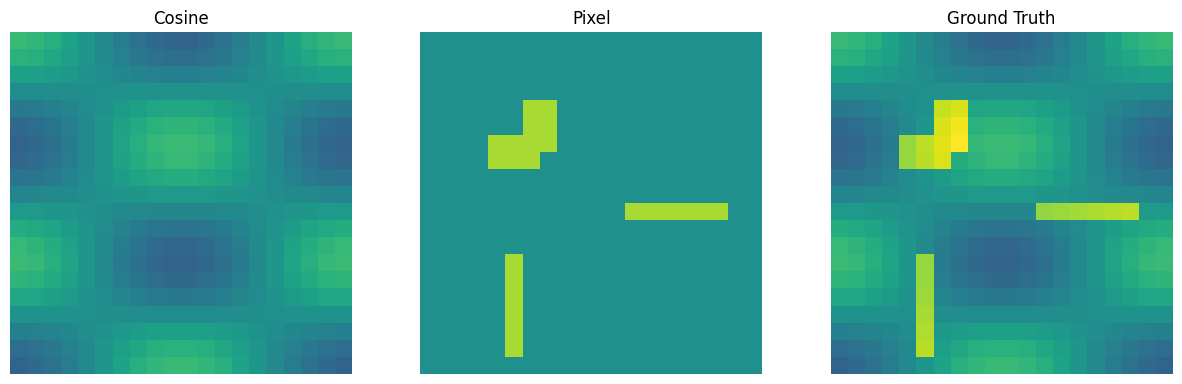

In [62]:
true_cosine_coefficients = np.zeros((Nx * Ny))
true_cosine_coefficients[3 * Ny + 2] = 1
true_cosine_image = cosine(true_cosine_coefficients)

true_pixel_coefficients = np.zeros((Nx, Ny))
true_pixel_coefficients[4:7, 6:8] = 0.2
true_pixel_coefficients[6:8, 4:7] = 0.2
true_pixel_coefficients[10, 12:18] = 0.2
true_pixel_coefficients[13:19, 5] = 0.2
true_pixel_coefficients = true_pixel_coefficients.flatten()
true_pixle_image = pixel(true_pixel_coefficients)

true_image = true_pixle_image + true_cosine_image
vmax = np.max(true_image)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(true_cosine_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[0].set_title("Cosine")

axs[1].imshow(true_pixle_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[1].set_title("Pixel")

axs[2].imshow(true_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[2].set_title("Ground Truth")

[ax.axis("off") for ax in axs]

Create a synthetic noiseless dataset.  The forward model here is simple path integration for paths that travel all the way across the image

$$d_i = \int_{\Gamma_i} f(x,y) \mathrm{d}s_i$$

(-0.5, 19.5, 19.5, -0.5)

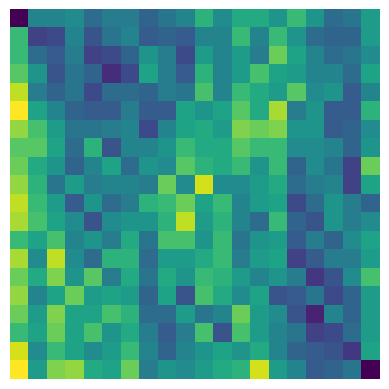

In [63]:
npaths=500
measurement = PathIntegral(Nx, Ny, npaths=npaths)

pm = np.sum(measurement.path_matrix.reshape((npaths, Nx, Ny)), axis=0)
plt.imshow(pm)
plt.gca().axis("off")

In [64]:
synthetic = measurement(true_image)

## Overcomplete Basis

Create an overcomplete basis, weighting the two bases and overall regularisation evenly

In [65]:
cosine.compute_jacobian(measurement)
pixel.compute_jacobian(measurement)
overcomplete = OvercompleteBasis(synthetic, [cosine, pixel], bweights=[1, 1], rweight=1e-3)

## Solve the inverse problem

Minimise the cost function

In [66]:
# should implement a cost function gradient for faster convergence
result = minimize(
    overcomplete.cost,
    rng.uniform(-1, 1, nparams),
    method="L-BFGS-B",
    jac=overcomplete.cost_gradient,
)

[(-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5)]

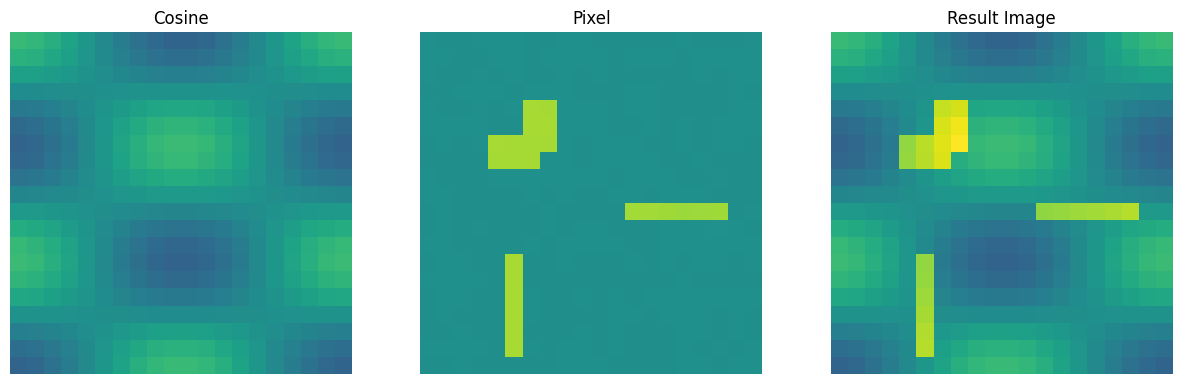

In [67]:
result_coefficients = overcomplete._split(result.x)

result_cosine_image = cosine(result_coefficients[0])
result_pixel_image = pixel(result_coefficients[1])
result_image = result_cosine_image + result_pixel_image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(result_cosine_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[0].set_title("Cosine")

axs[1].imshow(result_pixel_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[1].set_title("Pixel")

axs[2].imshow(result_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[2].set_title("Result Image")

[ax.axis("off") for ax in axs]

[(-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5)]

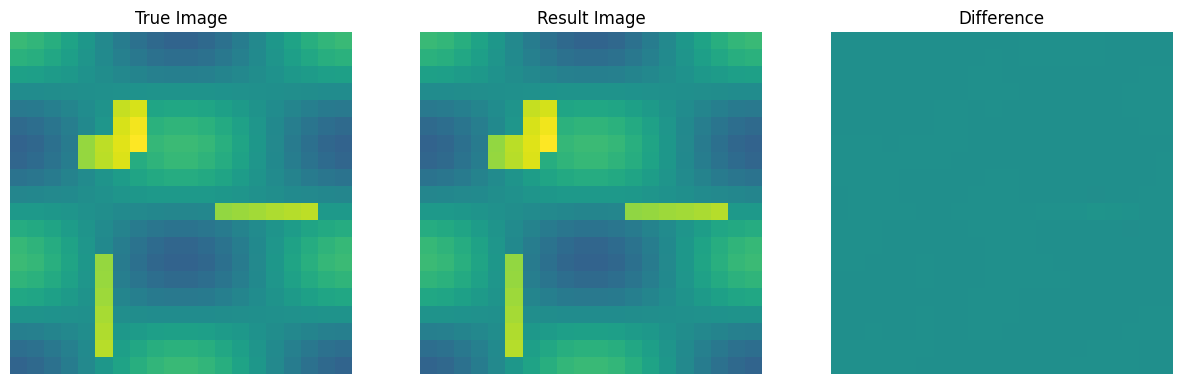

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(true_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[0].set_title("True Image")

axs[1].imshow(result_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[1].set_title("Result Image")

axs[2].imshow((true_image - result_image).reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[2].set_title("Difference")

[ax.axis("off") for ax in axs]

## Visualise Coeffificient Distributions

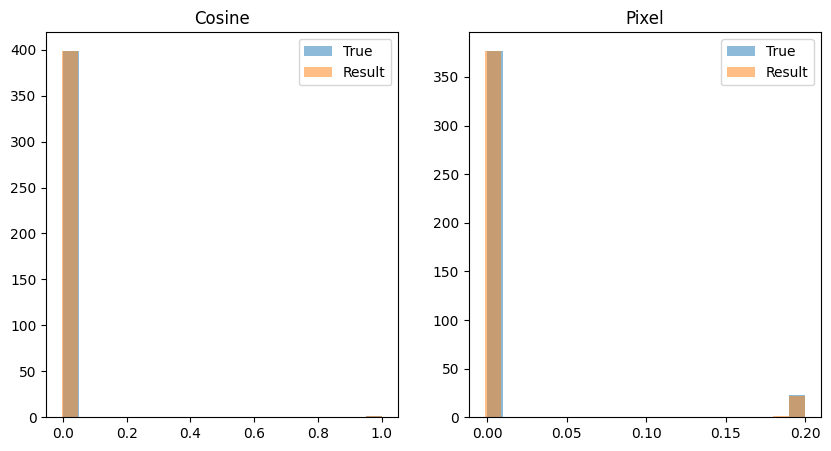

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(true_cosine_coefficients, bins=20, alpha=0.5, label="True")
axs[0].hist(result_coefficients[0], bins=20, alpha=0.5, label="Result")
axs[0].set_title("Cosine")

axs[1].hist(true_pixel_coefficients, bins=20, alpha=0.5, label="True")
axs[1].hist(result_coefficients[1], bins=20, alpha=0.5, label="Result")
axs[1].set_title("Pixel")

[ax.legend() for ax in axs]

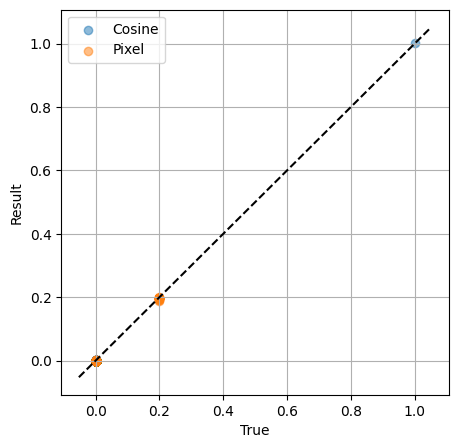

In [70]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.scatter(true_cosine_coefficients, result_coefficients[0], alpha=0.5, label="Cosine")
axs.scatter(true_pixel_coefficients, result_coefficients[1], alpha=0.5, label="Pixel")
axs.set_xlabel("True")
axs.set_ylabel("Result")

_min = np.min([axs.get_xlim()[0], axs.get_ylim()[0]])
_max = np.max([axs.get_xlim()[1], axs.get_ylim()[1]])
axs.plot([_min, _max], [_min, _max], color="black", ls="--")
axs.grid()
axs.legend()